In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, BatchNormalization, LeakyReLU
from keras.layers.merge import concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
# from tensorflow import set_random_seed
import tensorflow as tf
from skimage.io import imread
from PIL import Image
from skimage.transform import resize
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import *
import image_utils as iu


In [2]:
face_scrub_actors_data = os.path.join('data/faceScrub', 'facescrub_actors.txt')
face_scrub_actress_data = os.path.join(
    'data/faceScrub', 'facescrub_actresses.txt')
data_path = '/Users/ernestopoku-kwarteng/Documents/Pycharm Projects/Anaconda/Machine-Learning/HandWriting Detection/bounding-box-predictions/data'
actors_dir = os.path.join(data_path, 'actors')
actress_dir = os.path.join(data_path, 'actress')
images_path = ''


In [3]:
def load_image(path):
    return imread(path)


In [9]:
def read_image(path):
    img = Image.open(path).convert('RGB')
    return img
    #return np.asarray(img) YCbCr


In [5]:
def display_image(image):
    fig = plt.figure
    plt.imshow(image, cmap='brg')


In [6]:
def display_ycbcr_image(image):
    fig = plt.figure
    plt.imshow(image, cmap='YCbCr')


In [7]:
def get_all_files(path):
    onlyfiles = [f for f in os.listdir(
        path) if os.path.isfile(os.path.join(path, f))]
    return onlyfiles


In [3]:
actor_image_paths = iu.get_all_files(actors_dir) 
actress_image_paths = iu.get_all_files(actress_dir)

In [4]:
for x in range(len(actor_image_paths)):
    actor_image_paths[x] = os.path.join(actors_dir, actor_image_paths[x])
for x in range(len(actress_image_paths)):
    actress_image_paths[x] = os.path.join(actress_dir, actress_image_paths[x])


In [5]:
image_paths = [None]* (len(actor_image_paths) + len(actress_image_paths))

In [6]:
image_paths = [actor_image_paths, actress_image_paths]


In [7]:
image_paths = [item for sublist in image_paths for item in sublist]


In [2]:
#get all the image path.
path = '/Users/ernestopoku-kwarteng/Documents/Pycharm Projects/Anaconda/Machine-Learning/deep-compression/data/room'
image_paths = iu.get_all_files(
    path)
for x in range(len(image_paths)):
    image_paths[x] = os.path.join(path, image_paths[x])


In [3]:
#read all the images on the disk as rgb
images = []
for x in range(len(image_paths)):
    try:
       images.append(iu.read_image(image_paths[x], 'RGB'))
    except:
       pass

In [4]:
len(images)

101

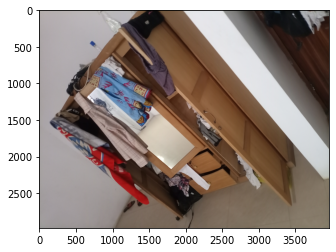

In [5]:
iu.display_image(images[5])

In [370]:
#Convert all images to gray-scale
def convert_to_gray_scale(image):
    image = np.array(image, np.uint8)
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


In [13]:
def get_new_image_dimen(image, new_dimen):
    width = image.width
    height = image.height
    new_width = 0
    new_height = 0
    aspect_ratio = width / height
    if width > height:
        new_width = new_dimen
        new_height = new_dimen / aspect_ratio
    else:
        new_height = new_dimen
        new_width = new_dimen * aspect_ratio
    return (new_width, new_height)


In [14]:
def pad_image(image, max_size):
    old_image_height, old_image_width, channels = image.shape
    # create new image of desired size and color (blue) for padding
    new_image_width = max_size
    new_image_height = max_size
    color = (0, 0, 0)
    result = np.full((new_image_height, new_image_width,
                      channels), color, dtype=np.uint8)
    # compute center offset
    x_center = (new_image_width - old_image_width) // 2
    y_center = (new_image_height - old_image_height) // 2
    # print(image)
    # copy img image into center of result image
    # result[y_center:y_center+old_image_height,x_center:x_center+old_image_width] = image
    result[0:old_image_height, 0:old_image_width] = image
    return result


In [6]:
# resize the image. The aspect ratio of the image is maintained.
new_dimen = 720
for x in range(len(images)):
    new_width, new_height = iu.get_new_image_dimen(images[x], new_dimen)
    images[x] = images[x].resize((int(new_width), int(new_height))) #resize(images[x], new_width, new_height)


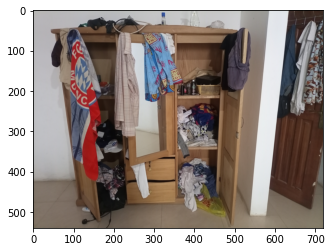

In [7]:
# display resized image
iu.display_image(images[0])

In [8]:
#images are converted to numpy arrays to be padded.
for x in range(len(images)):
    images[x] = np.asarray(images[x])

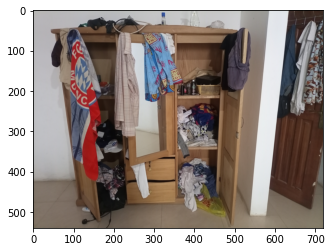

In [9]:
# display resized image
iu.display_image(images[0])


In [10]:
# since the images do not have the same aspect ratios,
# the image is padded to have the same aspect ratios. 
for x in range(len(images)):
    images[x] = iu.pad_image(images[x], new_dimen)


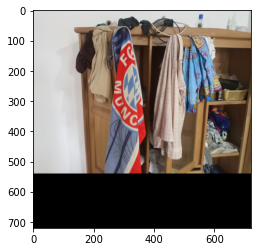

In [11]:
# display padded image
iu.display_image(images[1])

In [19]:
def convert_np_rgb_image_to_ycbcr(image):
    return Image.fromarray(image).convert('YCbCr')


In [18]:
def get_y_channel_from_ycbcr(ycbcr_image):
    return np.asarray(ycbcr_image.getchannel('Y'))


In [12]:
def get_y_channel(image):
    return image[:, :, 0]


In [13]:
def get_cbcr_channel(image):
    cb_channel = image[:, :, 1]
    cr_channel = image[:, :, 2]
    cb_cr = np.empty(shape=(image.shape[0], image.shape[1], 2))
    cb_cr[:, :, 0] = cb_channel
    cb_cr[:, :, 1] = cr_channel
    return np.array(cb_cr)


In [26]:
def combine_y_to_cbcr_channel(y_image, cbcr_image):
    new_im = [None] * y_image.shape[0]
    for r in range(y_image.shape[0]):
        row_y = y_image[r]
        row_cbcr = cbcr_image[r]
        new_row = [None] * row_y.shape[0]
        for p in range(row_y.shape[0]):
            new_row[p] = [row_y[p][0], row_cbcr[p][0], row_cbcr[p][1]]
        new_im[r] = new_row
    return np.array(new_im)


In [14]:
# rgb np array is converted ycbcr color space
for x in range(len(images)):
    images[x] = iu.rgb2ycbcr(images[x]); # convert_np_rgb_image_to_ycbcr(images[x])


In [15]:
images[1].shape

(720, 720, 3)

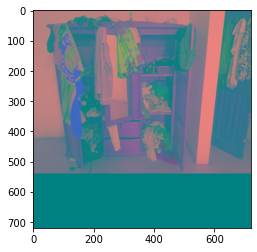

In [16]:
# display ycbcr image
iu.display_image(images[0])


In [17]:
images_y_channel = [None] * len(images)
# y channel is extracted from the ycbcr color space
for x in range(len(images)):
    images_y_channel[x] = get_y_channel(images[x])


In [18]:
images_cb_cr_channel = [None] * len(images)
for x in range(len(images)):
    images_cb_cr_channel[x] = get_cbcr_channel(images[x])


In [19]:
images = None

In [54]:
images.shape

AttributeError: 'list' object has no attribute 'shape'

In [26]:
# for x in range(len(images)):
#     images[x] = np.asarray(images[x])
ycbcr_images = np.array(images) / 255

In [59]:
ycbcr_images.shape

(4317, 240, 240, 3)

In [20]:
images_cb_cr_channel = np.array((images_cb_cr_channel)) / 255
images_y_channel = np.array(images_y_channel) / 255


In [49]:
images_cb_cr_channel.min()

0.2

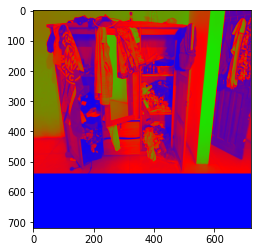

In [21]:
iu.display_image(images_y_channel[0])

In [ ]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False,
                   input_shape=(96, 96, 3), input_tensor=Input(shape=(150, 150, 3)))
base_model.trainable = False  # Not trainable weights
base_model.summary()


In [63]:

#Encoder
encoder_input = Input(shape=(240, 240, 1,))
encoder_output = Conv2D(64, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(512, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(encoder_output)
#Decoder
decoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(encoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(64, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(16, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(3, (3, 3), activation='sigmoid',
                        padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
model = Model(inputs=encoder_input, outputs=decoder_output)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 1)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 120, 120, 64)      640       
                                                                 
 conv2d_14 (Conv2D)          (None, 120, 120, 128)     73856     
                                                                 
 conv2d_15 (Conv2D)          (None, 60, 60, 128)       147584    
                                                                 
 conv2d_16 (Conv2D)          (None, 60, 60, 256)       295168    
                                                                 
 conv2d_17 (Conv2D)          (None, 30, 30, 256)       590080    
                                                                 
 conv2d_18 (Conv2D)          (None, 30, 30, 512)       1180

In [340]:
#Encoder
encoder_input = Input(shape=(240, 240, 1,))
encoder_output = Conv2D(64, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_output)

encoder_output = MaxPooling2D(pool_size=(2, 2), padding='same')(encoder_output)

encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3, 3), activation='relu',
                        padding='same')(encoder_output)

encoder_output = MaxPooling2D(pool_size=(2, 2), padding='same')(encoder_output)

encoder_output = Conv2D(512, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(encoder_output)

encoder_output = MaxPooling2D(pool_size=(2, 2), padding='same')(encoder_output)

encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(encoder_output)

encoder_output = MaxPooling2D(pool_size=(2, 2), padding='same')(encoder_output)
encoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(64, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = MaxPooling2D(pool_size=(2, 2), padding='same')(encoder_output)
#Decoder
decoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(encoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = UpSampling2D((4, 4))(decoder_output)
decoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(512, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(512, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = UpSampling2D((3, 3))(decoder_output)
decoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = UpSampling2D((5, 5))(decoder_output)
decoder_output = Conv2D(64, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(32, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(16, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(3, (3, 3), activation='sigmoid',
                        padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
model = Model(inputs=encoder_input, outputs=decoder_output)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()


Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 240, 240, 1)]     0         
                                                                 
 conv2d_271 (Conv2D)         (None, 120, 120, 64)      640       
                                                                 
 conv2d_272 (Conv2D)         (None, 120, 120, 128)     73856     
                                                                 
 conv2d_273 (Conv2D)         (None, 60, 60, 128)       147584    
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 30, 30, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_274 (Conv2D)         (None, 30, 30, 256)       295168    
                                                          

In [22]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow
    # Proper initialization prevents from the problem of exploding and vanishing gradients
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)

    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions
    skip_connection = conv

    return next_layer, skip_connection


def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
        n_filters,
        (3, 3),    # Kernel size
        strides=(2, 2),
        padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)

    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters,
                  3,     # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    return conv


In [23]:
input_size = (720, 720, 1)
n_filters = 32
n_classes = 2

# Input size represent the size of 1 image (the size used for pre-processing)
inputs = Input(input_size)

# Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
# Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image
cblock1 = EncoderMiniBlock(inputs, n_filters, dropout_prob=0, max_pooling=True)
cblock2 = EncoderMiniBlock(
    cblock1[0], n_filters*2, dropout_prob=0, max_pooling=True)
cblock3 = EncoderMiniBlock(
    cblock2[0], n_filters*4, dropout_prob=0, max_pooling=True)
cblock4 = EncoderMiniBlock(
    cblock3[0], n_filters*8, dropout_prob=0.3, max_pooling=True)
cblock5 = EncoderMiniBlock(
    cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

# Decoder includes multiple mini blocks with decreasing number of filters
# Observe the skip connections from the encoder are given as input to the decoder
# Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

# Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
# Followed by a 1x1 Conv layer to get the image to the desired size.
# Observe the number of channels will be equal to number of output classes
conv9 = Conv2D(n_filters,
               3,
               activation='relu',
               padding='same',
               kernel_initializer='he_normal')(ublock9)

conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

# Define the model
model = tf.keras.Model(inputs=inputs, outputs=conv10)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()


2022-04-23 12:00:52.292051: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 720, 720, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 720, 720, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 720, 720, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

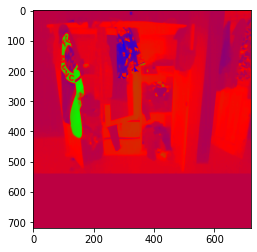

In [46]:
iu.display_image(images_cb_cr_channel[0][:, :, 1])



In [53]:
# model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(images_y_channel, images_cb_cr_channel, batch_size=20,
          validation_split=0.1, epochs=20)


Epoch 1/20
5/5 [==============================] - 445s 90s/step - loss: 0.0013 - accuracy: 0.7276 - val_loss: 0.0012 - val_accuracy: 0.7361
Epoch 2/20
5/5 [==============================] - 496s 97s/step - loss: 0.0013 - accuracy: 0.7545 - val_loss: 0.0012 - val_accuracy: 0.7536
Epoch 3/20
5/5 [==============================] - 507s 97s/step - loss: 0.0013 - accuracy: 0.7648 - val_loss: 0.0012 - val_accuracy: 0.7562
Epoch 4/20
5/5 [==============================] - 485s 93s/step - loss: 0.0013 - accuracy: 0.7753 - val_loss: 0.0012 - val_accuracy: 0.7545
Epoch 5/20
5/5 [==============================] - 511s 101s/step - loss: 0.0012 - accuracy: 0.7578 - val_loss: 0.0012 - val_accuracy: 0.7540
Epoch 6/20
5/5 [==============================] - 484s 92s/step - loss: 0.0012 - accuracy: 0.7575 - val_loss: 0.0012 - val_accuracy: 0.7576
Epoch 7/20
5/5 [==============================] - 470s 92s/step - loss: 0.0012 - accuracy: 0.7572 - val_loss: 0.0011 - val_accuracy: 0.7610
Epoch 8/20
5/5 [===

In [56]:
model.save('auto_color_room_model.h5')

In [27]:
def show_predictions(path):
    test_image = iu.read_image(
        path, 'RGB')
    # resize image
    new_width, new_height = iu.get_new_image_dimen(test_image, new_dimen)
    test_image = test_image.resize((int(new_width), int(new_height)))
    test_image = np.asarray(test_image)
    # pad image
    test_image = iu.pad_image(test_image, new_dimen)
    # rgb np array is converted ycbcr color space
    test_image = iu.rgb2ycbcr(test_image)
    test_image = get_y_channel(test_image) / 255
    output = model.predict(np.array([test_image]))
    cbcr_image = output[0] * 255
    test_image = test_image.reshape(new_dimen, new_dimen, 1)
    test_image = test_image * 255
    ycbcr_image = combine_y_to_cbcr_channel(test_image, cbcr_image)
    rgb_image = iu.ycbcr2rgb(ycbcr_image)
    iu.display_image(rgb_image)


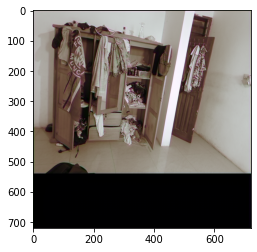

In [55]:
show_predictions(
    '/Users/ernestopoku-kwarteng/Documents/Pycharm Projects/Anaconda/Machine-Learning/deep-compression/data/room/IMG_20220423_104254_248.jpg')


In [70]:
y_image = images_y_channel[100]
output = model.predict(np.array([y_image]))


In [51]:
def combine_y_to_cbcr_channel(y_image, cbcr_image):
    new_im = [None] * y_image.shape[0]
    for r in range(y_image.shape[0]):
        row_y = y_image[r]
        row_cbcr = cbcr_image[r]
        new_row = [None] * row_y.shape[0]
        for p in range(row_y.shape[0]):
            new_row[p] = [row_y[p][0], row_cbcr[p][0], row_cbcr[p][1]]
        new_im[r] = new_row
    return np.array(new_im)


In [71]:
y_image = y_image.reshape(240,240,1)

In [72]:
ycbcr_image = output[0] * 255


In [73]:
rgb = iu.ycbcr2rgb(ycbcr_image)

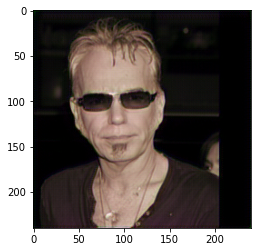

In [74]:
iu.display_image(rgb)

In [276]:
ycbcr_image = output[0] * 255
y_image = y_image * 255
ycbcr_image = combine_y_to_cbcr_channel(y_image,cbcr_image)


In [105]:
ycbcr_image


array([[[ 83.        , 115.40117645, 134.60559082],
        [ 69.        , 115.40117645, 134.60559082],
        [ 62.        , 115.40117645, 134.60559082],
        ...,
        [  0.        , 127.86935425, 127.99375916],
        [  0.        , 127.86935425, 127.99375916],
        [  0.        , 127.86935425, 127.99375916]],

       [[ 79.        , 115.40117645, 134.60559082],
        [ 64.        , 115.40117645, 134.60559082],
        [ 61.        , 115.40117645, 134.60559082],
        ...,
        [  0.        , 127.86935425, 127.99375916],
        [  0.        , 127.86935425, 127.99375916],
        [  0.        , 127.86935425, 127.99375916]],

       [[ 53.        , 115.40117645, 134.60559082],
        [ 49.        , 115.40117645, 134.60559082],
        [ 55.        , 115.40117645, 134.60559082],
        ...,
        [  0.        , 127.86935425, 127.99375916],
        [  0.        , 127.86935425, 127.99375916],
        [  0.        , 127.86935425, 127.99375916]],

       ...,

      

In [277]:
rgb_image = iu.ycbcr2rgb(ycbcr_image)


In [106]:
rgb_image

array([[[ 92,  82,  60],
        [ 78,  68,  46],
        [ 71,  61,  39],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 88,  78,  56],
        [ 73,  63,  41],
        [ 70,  60,  38],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 62,  52,  30],
        [ 58,  48,  26],
        [ 64,  54,  32],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[114, 108,  88],
        [138, 132, 112],
        [143, 137, 117],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[105,  99,  79],
        [130, 124, 104],
        [136, 130, 110],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 99,  93,  73],
        [120, 114,  94],
        [128, 122, 102],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

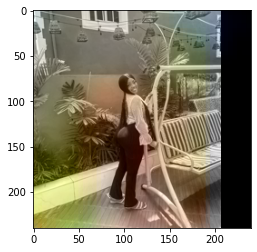

In [278]:
iu.display_image(rgb_image)

In [182]:
def ycbcr2rgb(im):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(np.float)
    rgb[:, :, [1, 2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)


In [310]:
image = output[0] * 255
rgb_image =ycbcr2rgb(image)


/var/folders/kh/ldlc522d21lbvxg7zwz8yh8r0000gn/T/ipykernel_67439/1384511715.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rgb = im.astype(np.float)


In [92]:
#test image
test_image = read_image(
    '/Users/ernestopoku-kwarteng/Documents/Pycharm Projects/Anaconda/Machine-Learning/deep-compression/data/oooo.jpeg')


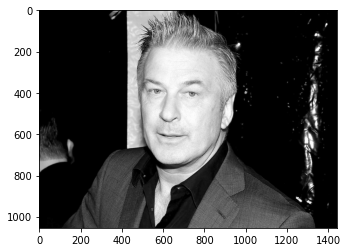

In [93]:
iu.display_image(test_image)


In [94]:
# resize image
new_width, new_height = iu.get_new_image_dimen(test_image, new_dimen)
test_image = test_image.resize((int(new_width), int(new_height)))


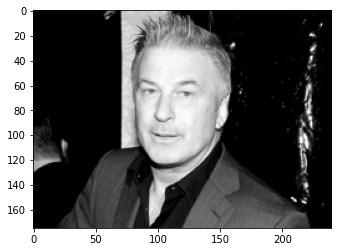

In [95]:
iu.display_image(test_image)


In [96]:
test_image = np.asarray(test_image)


In [97]:
# pad image
test_image = iu.pad_image(test_image, 240)


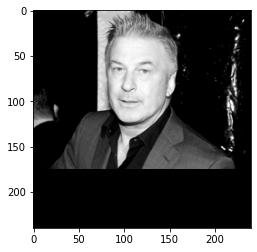

In [98]:
iu.display_image(test_image)


In [99]:
# rgb np array is converted ycbcr color space
test_image = iu.rgb2ycbcr(test_image)


In [100]:
test_image = get_y_channel(test_image)


In [37]:
test_image.shape

(240, 240)

In [101]:
test_image = test_image / 255


In [102]:
output = model.predict(np.array([test_image]))

In [103]:
ycbcr_image = output[0]
ycbcr_image = ycbcr_image * 255

In [104]:
cbcr_image = get_cbcr_channel(ycbcr_image)

In [67]:
cbcr_image = ycbcr_image

In [105]:
test_image = test_image.reshape(240, 240, 1)
test_image = test_image * 255

In [106]:
# test_cbcr_image = output[0] * 255
# # y_image = y_image * 255
# test_image = test_image * 255
ycbcr_image = combine_y_to_cbcr_channel(test_image, cbcr_image)


In [107]:
rgb_image = iu.ycbcr2rgb(ycbcr_image)

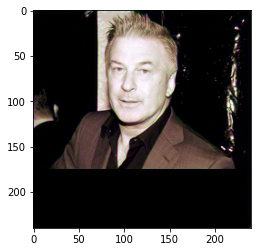

In [108]:
iu.display_image(rgb_image)
